# Importing the Libraries

In [32]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from keras.preprocessing import image                  
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from PIL import ImageFile               

In [2]:
!ls

 augmented_data				      model
 config.ini				      model_dance_recognition.png
'Dance Recognition Data Augmentation.ipynb'   submission.csv
'Dance Recognition.ipynb'		      temp_img.jpg
 data					      test.csv
 dataset				      train_augmented.csv
 genData.py				      train.csv


In [3]:
TEST_DIR = os.path.join(os.getcwd(),"dataset","test")
TRAIN_DIR = os.path.join(os.getcwd(),"augmented_data")
MODEL_PATH = os.path.join(os.getcwd(),"model")

In [4]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
    

In [5]:
data_train = pd.read_csv(os.path.join(os.getcwd(),"train_augmented.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"test.csv"))

In [6]:
print("The number of training images is ",data_train.shape[0])
print("The number of testing images is ",data_test.shape[0]) # for submission

The number of training images is  9962
The number of testing images is  156


In [7]:
data_train.head()

,FileName,ClassName
0,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
1,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
2,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
3,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
4,/home/abhinav/dance_recognition/augmented_data...,kuchipudi


In [8]:
data_train['FileName'] = data_train['FileName'].apply(lambda x:os.path.join(TRAIN_DIR,"/".join(x.split("/")[-2:])))
data_test['Image'] = data_test['Image'].apply(lambda x:os.path.join(os.getcwd(),"dataset","test",x))

In [9]:
data_train.head()

,FileName,ClassName
0,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
1,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
2,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
3,/home/abhinav/dance_recognition/augmented_data...,kuchipudi
4,/home/abhinav/dance_recognition/augmented_data...,kuchipudi


In [10]:
data_test.head()

,Image
0,/home/abhinav/dance_recognition/dataset/test/5...
1,/home/abhinav/dance_recognition/dataset/test/2...
2,/home/abhinav/dance_recognition/dataset/test/4...
3,/home/abhinav/dance_recognition/dataset/test/4...
4,/home/abhinav/dance_recognition/dataset/test/1...


In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9962 entries, 0 to 9961
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FileName   9962 non-null   object
 1   ClassName  9962 non-null   object
dtypes: object(2)
memory usage: 155.8+ KB


In [12]:
data_train.describe()

,FileName,ClassName
count,9962,9962
unique,9962,8
top,/home/abhinav/dance_recognition/augmented_data...,mohiniyattam
freq,1,1250


In [13]:
data_train['ClassName'].value_counts()

mohiniyattam     1250
odissi           1248
bharatanatyam    1247
kathakali        1247
kuchipudi        1246
sattriya         1244
kathak           1244
manipuri         1236
Name: ClassName, dtype: int64

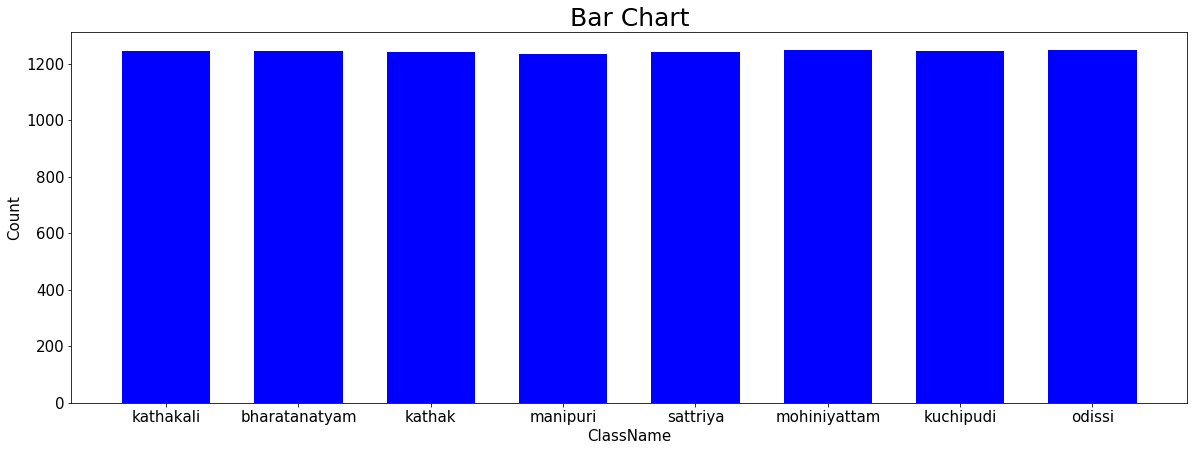

In [14]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('ClassName',size=15)
plt.ylabel('Count',size=15)

plt.show()

1. The classes are well separated and equally balanced into 8 classes

In [15]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'sattriya': 0, 'odissi': 1, 'kathakali': 2, 'mohiniyattam': 3, 'bharatanatyam': 4, 'kuchipudi': 5, 'manipuri': 6, 'kathak': 7}


In [16]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(9962, 8)


In [17]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:
           
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5
test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5

100%|██████████| 156/156 [00:01<00:00, 115.34it/s]


In [19]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)        

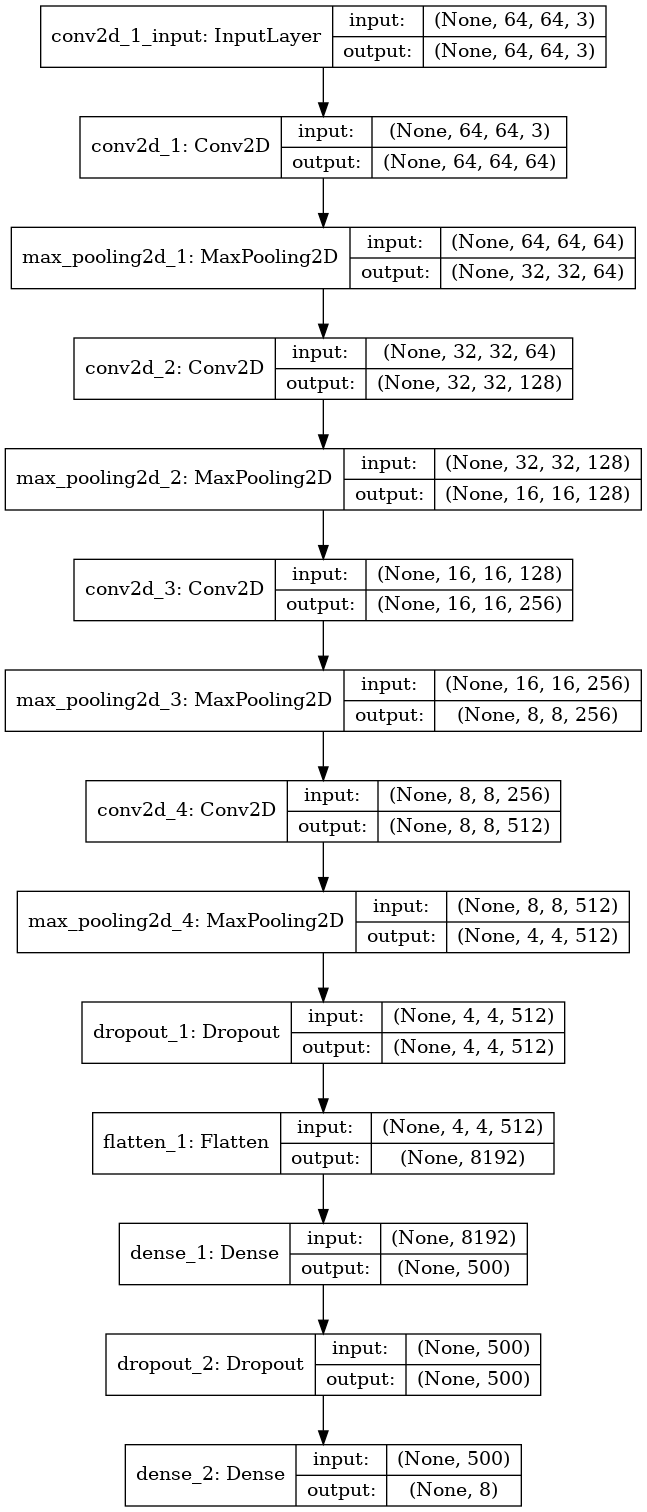

In [20]:
plot_model(model,to_file="model_dance_recognition.png",show_shapes=True,show_layer_names=True)

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
filepath = os.path.join(MODEL_PATH,"dance_recognition-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [23]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=10, batch_size=40, shuffle=True,callbacks=callbacks_list)

Train on 7969 samples, validate on 1993 samples
Epoch 1/10
7969/7969 [==============================] - 99s 12ms/step - loss: 1.3757 - accuracy: 0.4983 - val_loss: 0.7612 - val_accuracy: 0.7341

Epoch 00001: val_accuracy improved from -inf to 0.73407, saving model to /home/abhinav/dance_recognition/model/dance_recognition-01-0.73.hdf5
Epoch 2/10
7969/7969 [==============================] - 102s 13ms/step - loss: 0.2883 - accuracy: 0.9090 - val_loss: 0.0374 - val_accuracy: 0.9890

Epoch 00002: val_accuracy improved from 0.73407 to 0.98896, saving model to /home/abhinav/dance_recognition/model/dance_recognition-02-0.99.hdf5
Epoch 3/10
7969/7969 [==============================] - 104s 13ms/step - loss: 0.1024 - accuracy: 0.9684 - val_loss: 0.0082 - val_accuracy: 0.9985

Epoch 00003: val_accuracy improved from 0.98896 to 0.99849, saving model to /home/abhinav/dance_recognition/model/dance_recognition-03-1.00.hdf5
Epoch 4/10
7969/7969 [==============================] - 112s 14ms/step - loss

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [24]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [25]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [26]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
print(class_names)

['sattriya', 'odissi', 'kathakali', 'mohiniyattam', 'bharatanatyam', 'kuchipudi', 'manipuri', 'kathak']


In [28]:
ypred = model.predict(valid_tensors,verbose=1)

1993/1993 [==============================] - 6s 3ms/step


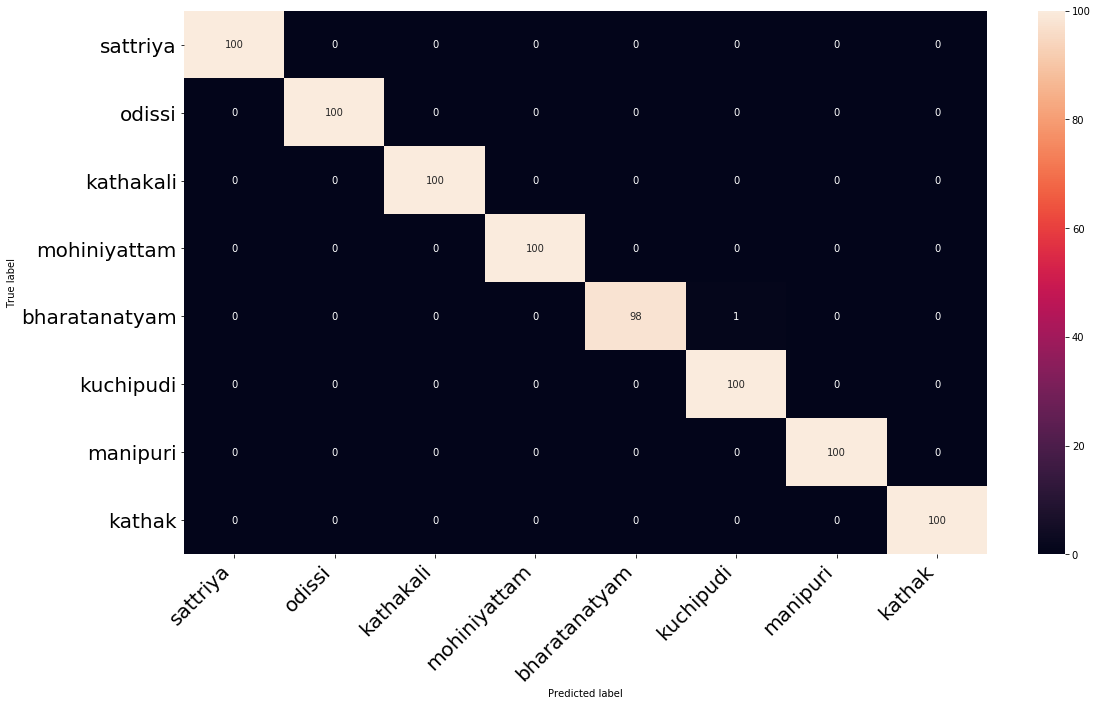

In [29]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [30]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [33]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.998495
Precision: 0.998512
Recall: 0.998495
F1 score: 0.998495


In [34]:
test_pred = model.predict(test_tensors,verbose=1)
test_pred_class = model.predict_classes(test_tensors)
# print(test_pred_class)
# print(test_pred_class.shape)
# print(test_pred_class.shape)

id_labels = dict()
for label,idx in labels_id.items():
    id_labels[idx]=label
# print(id_labels)

156/156 [==============================] - 0s 3ms/step


## Creating the Submission file

In [35]:
data_submit = list()
for i in range(test_pred_class.shape[0]):
    data_submit.append({
        "Image":data_test.iloc[i,0].split("/")[-1],
        "target":id_labels[test_pred_class[i]]
    })
data_submit = pd.DataFrame(data_submit)
data_submit.to_csv("submission.csv",index=False)